# Gearbox Fault Classification
## Notebook 1 — Synthetic Data Generation

**Author:** Bradley Nast  
**Thesis:** An Investigative Study into Gearbox Fault Classification Using a Signal Processing and Deep Learning Framework  
**University:** University of Pretoria, 2024  
**Supervisors:** Prof. PS Heyns, Luke van Eyk

---

This notebook implements a physics-based **8-DOF Lumped-Parameter Dynamic Model (LPDM)** of a single-stage spur gearbox to generate synthetic vibration data for downstream deep learning. The model is based on Mohammed et al. (2015) and parameterised from Chaari et al. (2012).

Six datasets are generated across two load conditions and three health states:

| Dataset | Load | Fault |
|---|---|---|
| 1_C_H | Constant | None |
| 2_C_CT | Constant | Cracked Tooth |
| 3_C_WT | Constant | Worn Teeth |
| 4_V_H | Varying | None |
| 5_V_CT | Varying | Cracked Tooth |
| 6_V_WT | Varying | Worn Teeth |

The pinion y-direction acceleration is extracted as the vibration signal, emulating an accelerometer measurement. Both the vibration signal and pinion angular velocity are saved as CSV files for downstream preprocessing and CNN training.

---
## 0. Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import scipy.signal as sig
import pandas as pd

# Plot styling
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')

Libraries loaded.


---
## Part 1 — 8-DOF Dynamic Model

The gearbox is modelled as an 8 degree-of-freedom planar mass-spring-damper system. The pinion and gear each contribute 3 DOF (x, y, θ), while the motor and load each contribute 1 DOF (θ). Gear tooth meshing is represented as a spring-damper joint with a Time-Varying Meshing Stiffness (TVMS).

The equations of motion are expressed in matrix form:

$$\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{F}(t)$$

where the state vector is ordered as: $[x_p, y_p, \theta_m, \theta_p, x_g, y_g, \theta_b, \theta_g]^T$

### 1.1. System Matrices

In [4]:
def mass_matrix(m_1, m_2, i_11, i_12, i_21, i_22):
    """
    8x8 diagonal mass/inertia matrix.
    State order: [xp, yp, theta_m, theta_p, xg, yg, theta_b, theta_g]
    """
    return np.array([
        [m_1, 0, 0, 0, 0, 0, 0, 0],
        [0, m_1, 0, 0, 0, 0, 0, 0],
        [0, 0, i_11, 0, 0, 0, 0, 0],
        [0, 0, 0, i_12, 0, 0, 0, 0],
        [0, 0, 0, 0, m_2, 0, 0, 0],
        [0, 0, 0, 0, 0, m_2, 0, 0],
        [0, 0, 0, 0, 0, 0, i_22, 0],
        [0, 0, 0, 0, 0, 0, 0, i_21]
    ])


def k_static(k_x1, k_y1, k_x2, k_y2, k_th1, k_th2):
    """
    Static stiffness matrix. Includes translational bearing stiffness
    and shaft torsional stiffness coupling motor-pinion and load-gear.
    """
    return np.array([
        [k_x1, 0, 0, 0, 0, 0, 0, 0],
        [0, k_y1, 0, 0, 0, 0, 0, 0],
        [0, 0, k_th1, -k_th1, 0, 0, 0, 0],
        [0, 0, -k_th1, k_th1, 0, 0, 0, 0],
        [0, 0, 0, 0, k_x2, 0, 0, 0],
        [0, 0, 0, 0, 0, k_y2, 0, 0],
        [0, 0, 0, 0, 0, 0, k_th2, -k_th2],
        [0, 0, 0, 0, 0, 0, -k_th2, k_th2]
    ])


def c_matrix(c_m, c_k, m_mat, k_mat):
    """
    Proportional (Rayleigh) damping matrix.
    C = c_m * M + c_k * K(t)
    Keeps damping ratio consistent as stiffness varies with TVMS.
    """
    return c_m * m_mat + c_k * k_mat


def s_matrix(alpha, r_pinion, r_gear):
    """
    Geometry matrix S relating meshing displacement and force DOF.
    Derived from tooth contact geometry at pressure angle alpha.
    """
    s3  = np.sin(alpha) ** 2
    s4  = np.cos(alpha) ** 2
    s5  = np.sin(alpha) * np.cos(alpha)
    s6  = r_pinion * np.cos(alpha)
    s7  = r_pinion * np.sin(alpha)
    s8  = r_gear * np.cos(alpha)
    s9  = r_gear * np.sin(alpha)
    s10 = r_pinion ** 2
    s11 = r_gear ** 2
    s12 = r_pinion * r_gear

    return np.array([
        [ s3,  s5, 0,  s7, -s3, -s5, 0,  s9],
        [ s5,  s4, 0,  s6, -s5, -s4, 0,  s8],
        [  0,   0, 0,   0,   0,   0, 0,   0],
        [ s7,  s6, 0, s10, -s7, -s6, 0, s12],
        [-s3, -s5, 0, -s7,  s3,  s5, 0, -s9],
        [-s5, -s4, 0, -s6,  s5,  s4, 0, -s8],
        [  0,   0, 0,   0,   0,   0, 0,   0],
        [ s9,  s8, 0, s12, -s9, -s8, 0, s11]
    ])

### 1.2. Time-Varying Meshing Stiffness (TVMS) & Fault Introduction

The TVMS is implemented as a rectangular step function (Chaari et al., 2012), alternating between $k_{gm,min}$ (single tooth pair in contact) and $k_{gm,max}$ (two tooth pairs in contact) based on the current angular position and contact ratio.

Faults are introduced by reducing the TVMS at specific tooth positions:
- **Tooth crack** — stiffness of a single tooth reduced by 10% (tooth 5)
- **Worn teeth** — stiffness of multiple adjacent teeth reduced by 10% (teeth 4, 5, 6)

A 10% reduction is chosen to represent **early-stage faults**, specifically to assess whether the CNN can detect faults before significant progression.

In [5]:
def k_gm_with_fault(theta_current, theta_cycle, c,
                    k_gm_min, k_gm_max,
                    fault_tooth=None, worn_teeth_range=None, wear_factor=1.0):
    """
    Time-Varying Meshing Stiffness with fault introduction.

    Implements the rectangular step TVMS from Chaari et al. (2012),
    with optional stiffness reductions for tooth crack and worn teeth faults.

    Parameters
    ----------
    theta_current    : float — current angular displacement of pinion [rad]
    theta_cycle      : float — angular displacement per gear mesh cycle [rad]
    c                : float — contact ratio
    k_gm_min         : float — minimum meshing stiffness (single tooth pair) [N/m]
    k_gm_max         : float — maximum meshing stiffness (two tooth pairs) [N/m]
    fault_tooth      : int   — tooth index with crack (None = no crack fault)
    worn_teeth_range : range — range of tooth indices with wear (None = no wear fault)
    wear_factor      : float — stiffness multiplier for worn teeth (< 1.0 = reduced)

    Returns
    -------
    k_gm : float — gear meshing stiffness at current angular position [N/m]
    """
    # Current position within gear rotation
    n_rotations = np.floor(theta_current / (2 * np.pi))
    theta_rel   = theta_current - (2 * np.pi * n_rotations)
    n_cycles    = np.floor(theta_rel / theta_cycle)
    theta_rel_c = theta_rel - (n_cycles * theta_cycle)

    # Base TVMS step function
    if theta_rel_c < (theta_cycle * (2 - c)):
        k_gm = k_gm_min
    else:
        k_gm = k_gm_max

    # Tooth crack: localised stiffness reduction at fault tooth
    if fault_tooth is not None and n_cycles == (fault_tooth - 1):
        k_gm *= 0.9   # 10% stiffness reduction

    # Worn teeth: distributed stiffness reduction over affected teeth
    if worn_teeth_range is not None and n_cycles in worn_teeth_range:
        k_gm *= wear_factor

    return k_gm

### 1.3. Motor Dynamics & Force Vector

The gearbox is driven by a squirrel cage induction motor (Chaari et al., 2012). Motor torque output is determined by the torque-speed relationship:

$$T_m = \frac{T_B}{\left(1 + \frac{g_b}{g_n}\right)^2 \left(\frac{c_{a1}}{g_n} - c_{a2}g_n^2\right)}$$

Two load conditions are simulated:
- **Constant load:** $T_b = -20$ Nm (equipment idling)
- **Varying load:** $T_b = -10\sin(2\pi t) + 30$ Nm (equipment operating)

In [10]:
def motor_dynamics(t_b, g_b, c_a1, c_a2, omega_r, omega_s, t_start=27.0):
    """
    Squirrel cage induction motor torque output.

    Parameters
    ----------
    t_b     : float — breakdown torque [Nm]
    g_b     : float — slip at breakdown torque
    c_a1    : float — motor constant 1
    c_a2    : float — motor constant 2
    omega_r : float — current rotor speed [rad/s]
    omega_s : float — synchronous speed [rad/s]
    t_start : float — startup torque [Nm]

    Returns
    -------
    T_m : float — motor output torque [Nm]
    """
    if np.abs(omega_r) < 1e-4:
        return t_start
    g_n = 1 - (omega_r / omega_s)
    return t_b / (1 + (g_b - g_n) ** 2 * ((c_a1 / g_n) - c_a2 * g_n ** 2))


def force_vector(omega_r, omega_s, t_b, g_b, c_a1, c_a2, time_i, dynamic=True, t_start=27.0, t_load_override=None):
    """
    External force/torque vector F(t) for the equations of motion.

    Parameters
    ----------
    omega_r  : float — current motor speed [rad/s]
    omega_s  : float — synchronous speed [rad/s]
    t_b      : float — motor breakdown torque [Nm]
    g_b      : float — slip at breakdown
    c_a1     : float — motor constant 1
    c_a2     : float — motor constant 2
    time_i   : float — current simulation time [s]
    dynamic  : bool  — True = varying load, False = constant load
    t_start  : float — startup torque [Nm]

    Returns
    -------
    f_vec : array — 8-element force vector
    """
    if t_load_override is not None:
        t_l = t_load_override
    elif dynamic:
        t_l = 10 * np.sin(2 * np.pi * time_i) + 30
    else:
        t_l = 20
    
    t_m = motor_dynamics(t_b, g_b, c_a1, c_a2, omega_r, omega_s, t_start)

    f_vec    = np.zeros(8)
    f_vec[2] = t_m
    f_vec[6] = t_l
    return f_vec

### 1.4. Newmark-Beta Solver

The equations of motion are solved using the **Newmark-Beta implicit integration scheme** (β=0.25, γ=0.5 — unconditionally stable). At each time step:

$$q_{n+1} = q_n + \Delta t \dot{q}_n + \Delta t^2 [(1-\beta)\ddot{q}_n + \beta\ddot{q}_{n+1}]$$
$$\dot{q}_{n+1} = \dot{q}_n + \Delta t [(1-\gamma)\ddot{q}_n + \gamma \ddot{q}_{n+1}]$$

The TVMS is updated at every step based on the current pinion angular displacement.

In [7]:
def newmark_solver(n_steps, dt, M, K_static, S_matrix, c_m, c_k, beta, gamma,
                   initial_conditions, force_func, stiffness_func,
                   theta_cycle, contact_ratio):
    """
    Newmark-Beta implicit time integration solver.

    Solves M*q'' + C*q' + K(t)*q = F(t) iteratively for all time steps.
    The stiffness matrix K(t) is updated at every step via the TVMS.

    Parameters
    ----------
    n_steps           : int      — number of time steps
    dt                : float    — time step [s]
    M                 : array    — mass matrix (8x8)
    K_static          : array    — static stiffness matrix (8x8)
    S_matrix          : array    — geometry matrix (8x8)
    c_m, c_k          : float    — proportional damping coefficients
    beta, gamma       : float    — Newmark integration parameters
    initial_conditions: dict     — {'u0', 'v0', 'a0'} initial state vectors
    force_func        : callable — F(omega_r, time_i) → force vector
    stiffness_func    : callable — k_gm(theta, theta_cycle, contact_ratio) → float
    theta_cycle       : float    — angular displacement per mesh cycle [rad]
    contact_ratio     : float    — gear contact ratio

    Returns
    -------
    u, v, a    : arrays — displacement, velocity, acceleration (n_steps x 8)
    F_store    : array  — force vectors at each step (n_steps x 8)
    k_gm_store : array  — TVMS values at each step (n_steps,)
    """
    dof        = M.shape[0]
    u          = np.zeros((n_steps, dof))
    v          = np.zeros((n_steps, dof))
    a          = np.zeros((n_steps, dof))
    F_store    = np.zeros((n_steps, dof))
    k_gm_store = np.zeros(n_steps)

    # Initial conditions
    u[0] = initial_conditions.get('u0', np.zeros(dof))
    v[0] = initial_conditions.get('v0', np.zeros(dof))
    a[0] = initial_conditions.get('a0', np.zeros(dof))

    k_gm_store[0] = stiffness_func(u[0][3], theta_cycle, contact_ratio)
    K_full        = K_static + k_gm_store[0] * S_matrix
    C_mat         = c_matrix(c_m, c_k, M, K_full)
    F_store[0, :] = force_func(v[0, 2], time_i=0)
    a[0, :]       = np.linalg.solve(M, F_store[0, :] - C_mat @ v[0, :] - K_full @ u[0, :])

    for i in range(1, n_steps):
        # Update TVMS and damping
        k_gm_value    = stiffness_func(u[i-1, 3], theta_cycle, contact_ratio)
        k_gm_store[i] = k_gm_value
        K_full        = K_static + k_gm_value * S_matrix
        C_mat         = c_matrix(c_m, c_k, M, K_full)

        # Effective stiffness and force
        K_eff = K_full + (gamma / (beta * dt)) * C_mat + (1 / (beta * dt**2)) * M
        F_eff = (F_store[i-1]
                 + M @ ((1 / (beta * dt**2)) * u[i-1]
                        + (1 / (beta * dt)) * v[i-1]
                        + (1 / (2 * beta) - 1) * a[i-1])
                 + C_mat @ ((gamma / (beta * dt)) * u[i-1]
                            + (gamma / beta - 1) * v[i-1]
                            + dt * (gamma / (2 * beta) - 1) * a[i-1]))

        # Solve for displacement, acceleration, velocity
        u[i] = np.linalg.solve(K_eff, F_eff)
        a[i] = ((1 / (beta * dt**2)) * (u[i] - u[i-1])
                - (1 / (beta * dt)) * v[i-1]
                - (1 / (2 * beta) - 1) * a[i-1])
        v[i] = v[i-1] + dt * ((1 - gamma) * a[i-1] + gamma * a[i])

        # Update force vector
        F_store[i, :] = force_func(v[i, 2], time_i=i * dt)

    return u, v, a, F_store, k_gm_store

---
## Part 2 — Simulation

### 2.1. System Parameters

In [8]:
# ── Simulation parameters ─────────────────────────────────────────────────────
dt         = 5e-6        # Time step [s] — Fs = 200 kHz
total_time = 5.0         # Simulation duration [s]
n_steps    = int(total_time / dt)
dof        = 8
beta, gamma = 0.25, 0.5  # Newmark parameters (unconditionally stable)
time       = np.linspace(0, total_time, n_steps)

# ── System matrices ───────────────────────────────────────────────────────────
# Mass & inertia (Chaari et al., 2012)
M = mass_matrix(
    m_1=0.6,       # Pinion mass [kg]
    m_2=1.5,       # Gear mass [kg]
    i_11=0.0043,   # Motor moment of inertia [kg.m²]
    i_12=0.00027,  # Pinion moment of inertia [kg.m²]
    i_21=0.0027,   # Gear moment of inertia [kg.m²]
    i_22=0.0045    # Load moment of inertia [kg.m²]
)

# Static stiffness
K_static_mat = k_static(
    k_x1=1e8, k_y1=1e8,   # Pinion translational stiffness [N/m]
    k_x2=1e8, k_y2=1e8,   # Gear translational stiffness [N/m]
    k_th1=1e5, k_th2=1e5  # Shaft torsional stiffness [N.m/rad]
)

# Geometry matrix
S_mat = s_matrix(
    alpha=np.radians(20),  # Pressure angle
    r_pinion=0.02819,      # Pinion pitch radius [m]
    r_gear=0.05638         # Gear pitch radius [m]
)

# Initial conditions
initial_conditions = {
    'u0': np.zeros(dof),
    'v0': np.zeros(dof),
    'a0': np.zeros(dof)
}

# ── Derived system parameters ─────────────────────────────────────────────────
Fs            = 1 / dt
Nt_pinion     = 20          # Pinion teeth
Nt_gear       = 40          # Gear teeth
omega_s       = 1500 * (2 * np.pi / 60)  # Synchronous speed [rad/s]
theta_cycle   = 2 * np.pi / Nt_pinion    # Angular displacement per mesh cycle [rad]
contact_ratio = 1.6

print(f'Simulation: {n_steps} steps at Fs = {Fs/1000:.0f} kHz')
print(f'Duration  : {total_time} s')
print(f'Pinion teeth: {Nt_pinion},  Gear teeth: {Nt_gear},  Gear ratio: {Nt_gear/Nt_pinion}')

Simulation: 999999 steps at Fs = 200 kHz
Duration  : 5.0 s
Pinion teeth: 20,  Gear teeth: 40,  Gear ratio: 2.0


### 2.2. Run All Six Simulations

> ⚠️ **Note:** Each simulation run takes several minutes at 200 kHz sampling. All 6 runs together may take 20–40 minutes depending on hardware. Results are saved as CSV files so this only needs to be run once.

In [9]:
# ── Dataset configurations ────────────────────────────────────────────────────
datasets = [
    {'id': '1_C_H',  'load_type': 'constant', 'fault_type': None},
    {'id': '2_C_CT', 'load_type': 'constant', 'fault_type': 'cracked_tooth'},
    {'id': '3_C_WT', 'load_type': 'constant', 'fault_type': 'worn_teeth'},
    {'id': '4_V_H',  'load_type': 'varying',  'fault_type': None},
    {'id': '5_V_CT', 'load_type': 'varying',  'fault_type': 'cracked_tooth'},
    {'id': '6_V_WT', 'load_type': 'varying',  'fault_type': 'worn_teeth'}
]

# ── Run simulations ───────────────────────────────────────────────────────────
results = {}
time_array = np.linspace(0, total_time, n_steps)

for config in datasets:
    dynamic_load = config['load_type'] == 'varying'

    # Fault configuration
    if config['fault_type'] == 'cracked_tooth':
        fault_tooth      = 5       # Crack localised to tooth 5
        worn_teeth_range = None
    elif config['fault_type'] == 'worn_teeth':
        fault_tooth      = None
        worn_teeth_range = range(3, 6)  # Wear distributed over teeth 4, 5, 6
    else:
        fault_tooth      = None
        worn_teeth_range = None

    force_func = lambda omega_r, time_i: force_vector(
        omega_r, omega_s=omega_s, t_b=32.0, g_b=0.315,
        c_a1=1.711, c_a2=1.316, time_i=time_i, dynamic=dynamic_load
    )

    stiffness_func = lambda theta, theta_cycle, contact_ratio: k_gm_with_fault(
        theta, theta_cycle, contact_ratio,
        k_gm_min=0.81e8, k_gm_max=2.1e8,
        fault_tooth=fault_tooth,
        worn_teeth_range=worn_teeth_range,
        wear_factor=0.9
    )

    print(f'Running simulation: {config["id"]} ({config["load_type"]} load, '
          f'fault={config["fault_type"]})...')

    u, v, a, F_store, k_gm_store = newmark_solver(
        n_steps=n_steps, dt=dt,
        M=M, K_static=K_static_mat, S_matrix=S_mat,
        c_m=0.05, c_k=1e-6,
        beta=beta, gamma=gamma,
        initial_conditions=initial_conditions,
        force_func=force_func,
        stiffness_func=stiffness_func,
        theta_cycle=theta_cycle,
        contact_ratio=contact_ratio
    )

    results[config['id']] = {
        'displacement': u,
        'velocity':     v,
        'acceleration': a,
        'force':        F_store,
        'stiffness':    k_gm_store
    }

    print(f'  Complete.')

print('\nAll simulations complete.')

Running simulation: 1_C_H (constant load, fault=None)...
  Complete.
Running simulation: 2_C_CT (constant load, fault=cracked_tooth)...
  Complete.
Running simulation: 3_C_WT (constant load, fault=worn_teeth)...
  Complete.
Running simulation: 4_V_H (varying load, fault=None)...
  Complete.
Running simulation: 5_V_CT (varying load, fault=cracked_tooth)...
  Complete.
Running simulation: 6_V_WT (varying load, fault=worn_teeth)...
  Complete.

All simulations complete.


### 2.3. Save Datasets

In [11]:
# ── Save each dataset ──────────────────────────────────────────────────
# Three columns required downstream:
#   Pinion_Y_Acceleration  — vibration signal (accelerometer)
#   Pinion_Angular_Velocity — shaft speed (for COT tachometer generation)
#   Motor_Angular_Velocity  — motor speed

import h5py

with h5py.File('gearbox_data.h5', 'w') as hdf:
    hdf.create_dataset('time', data=time_array, compression='gzip', compression_opts=6)
    for dataset_id, data in results.items():
        grp = hdf.create_group(dataset_id)
        grp.create_dataset('Pinion_Y_Acceleration',   data=data['acceleration'][:, 1], compression='gzip', compression_opts=6)
        grp.create_dataset('Pinion_Angular_Velocity', data=data['velocity'][:, 3],     compression='gzip', compression_opts=6)
        grp.create_dataset('Motor_Angular_Velocity',  data=data['velocity'][:, 2],     compression='gzip', compression_opts=6)

print('Saved gearbox_data.h5')

Saved gearbox_data.h5


### 2.4. Generate Unseen Datasets

In [12]:
# ── Unseen condition simulation ───────────────────────────────────────────────
CRACK_SEVERITY = 0.6   # 40% stiffness reduction (wear_factor = 1 - 0.4)

UNSEEN_CONFIGS = [
    {'id': 'unseen_H',  'fault_type': None,            'load': 30},
    {'id': 'unseen_CT', 'fault_type': 'cracked_tooth', 'load': 30},
    {'id': 'unseen_WT', 'fault_type': 'worn_teeth',    'load': 30},
]

# Simulation parameters — identical to Notebook 1
dt         = 5e-6
total_time = 5.0
n_steps    = int(total_time / dt)
dof        = 8
beta, gamma = 0.25, 0.5
time_array = np.linspace(0, total_time, n_steps)
omega_s    = 1500 * (2 * np.pi / 60)

M            = mass_matrix(m_1=0.6, m_2=1.5, i_11=0.0043, i_12=0.00027,
                           i_21=0.0027, i_22=0.0045)
K_static_mat = k_static(k_x1=1e8, k_y1=1e8, k_x2=1e8, k_y2=1e8,
                        k_th1=1e5, k_th2=1e5)
S_mat        = s_matrix(alpha=np.radians(20), r_pinion=0.02819, r_gear=0.05638)

initial_conditions = {'u0': np.zeros(dof), 'v0': np.zeros(dof), 'a0': np.zeros(dof)}
theta_cycle   = 2 * np.pi / 20
contact_ratio = 1.6

unseen_results = {}

for config in UNSEEN_CONFIGS:
    if config['fault_type'] == 'cracked_tooth':
        fault_tooth      = 5
        worn_teeth_range = None
    elif config['fault_type'] == 'worn_teeth':
        fault_tooth      = None
        worn_teeth_range = range(3, 6)
    else:
        fault_tooth      = None
        worn_teeth_range = None

    load_val = config['load']

    force_func = lambda omega_r, time_i, _load=load_val: force_vector(
        omega_r, omega_s=omega_s, t_b=32.0, g_b=0.315,
        c_a1=1.711, c_a2=1.316, time_i=time_i, dynamic=False,
        t_load_override=_load
    )

    stiffness_func = lambda theta, theta_cycle, contact_ratio: k_gm_with_fault(
        theta, theta_cycle, contact_ratio,
        k_gm_min=0.81e8, k_gm_max=2.1e8,
        fault_tooth=fault_tooth,
        worn_teeth_range=worn_teeth_range,
        wear_factor=CRACK_SEVERITY
    )

    print(f'Running unseen simulation: {config["id"]} (load={load_val} Nm, '
          f'fault={config["fault_type"]}, severity=40%)...')

    u, v, a, F_store, k_gm_store = newmark_solver(
        n_steps=n_steps, dt=dt,
        M=M, K_static=K_static_mat, S_matrix=S_mat,
        c_m=0.05, c_k=1e-6,
        beta=beta, gamma=gamma,
        initial_conditions=initial_conditions,
        force_func=force_func,
        stiffness_func=stiffness_func,
        theta_cycle=theta_cycle,
        contact_ratio=contact_ratio
    )

    unseen_results[config['id']] = {
        'acceleration': a,
        'velocity':     v
    }
    print(f'  Complete.')

# ── Save to HDF5 alongside training data ─────────────────────────────────────
HDF5_PATH = r"C:\Users\Brad\OneDrive\2. Projects\9. DS Porfolio\data-science-portfolio\projects\gearbox-fault-cnn\data\gearbox_data.h5"

with h5py.File(HDF5_PATH, 'a') as hdf:   # 'a' = append, preserves training data
    if 'unseen' in hdf:
        del hdf['unseen']                 # Clear old unseen group if re-running
    for dataset_id, data in unseen_results.items():
        grp = hdf.create_group(f'unseen/{dataset_id}')
        grp.create_dataset('Pinion_Y_Acceleration',   data=data['acceleration'][:, 1],
                           compression='gzip', compression_opts=6)
        grp.create_dataset('Pinion_Angular_Velocity', data=data['velocity'][:, 3],
                           compression='gzip', compression_opts=6)
    hdf.create_dataset('unseen/time', data=time_array,
                       compression='gzip', compression_opts=6)

print('Unseen condition data saved to gearbox_data.h5 under /unseen/')

# ── Load back for use downstream ──────────────────────────────────────────────
UNSEEN_IDS = ['unseen_H', 'unseen_CT', 'unseen_WT']

with h5py.File(HDF5_PATH, 'r') as hdf:
    unseen_vibration = [hdf[f'unseen/{ds_id}']['Pinion_Y_Acceleration'][:] for ds_id in UNSEEN_IDS]
    unseen_rotation  = [hdf[f'unseen/{ds_id}']['Pinion_Angular_Velocity'][:] for ds_id in UNSEEN_IDS]

print('Unseen data loaded and ready for evaluation.')

Running unseen simulation: unseen_H (load=30 Nm, fault=None, severity=40%)...
  Complete.
Running unseen simulation: unseen_CT (load=30 Nm, fault=cracked_tooth, severity=40%)...
  Complete.
Running unseen simulation: unseen_WT (load=30 Nm, fault=worn_teeth, severity=40%)...
  Complete.
Unseen condition data saved to gearbox_data.h5 under /unseen/
Unseen data loaded and ready for evaluation.


---
## Part 3 — Signal Validation

### 3.1. Motor & Load Torques

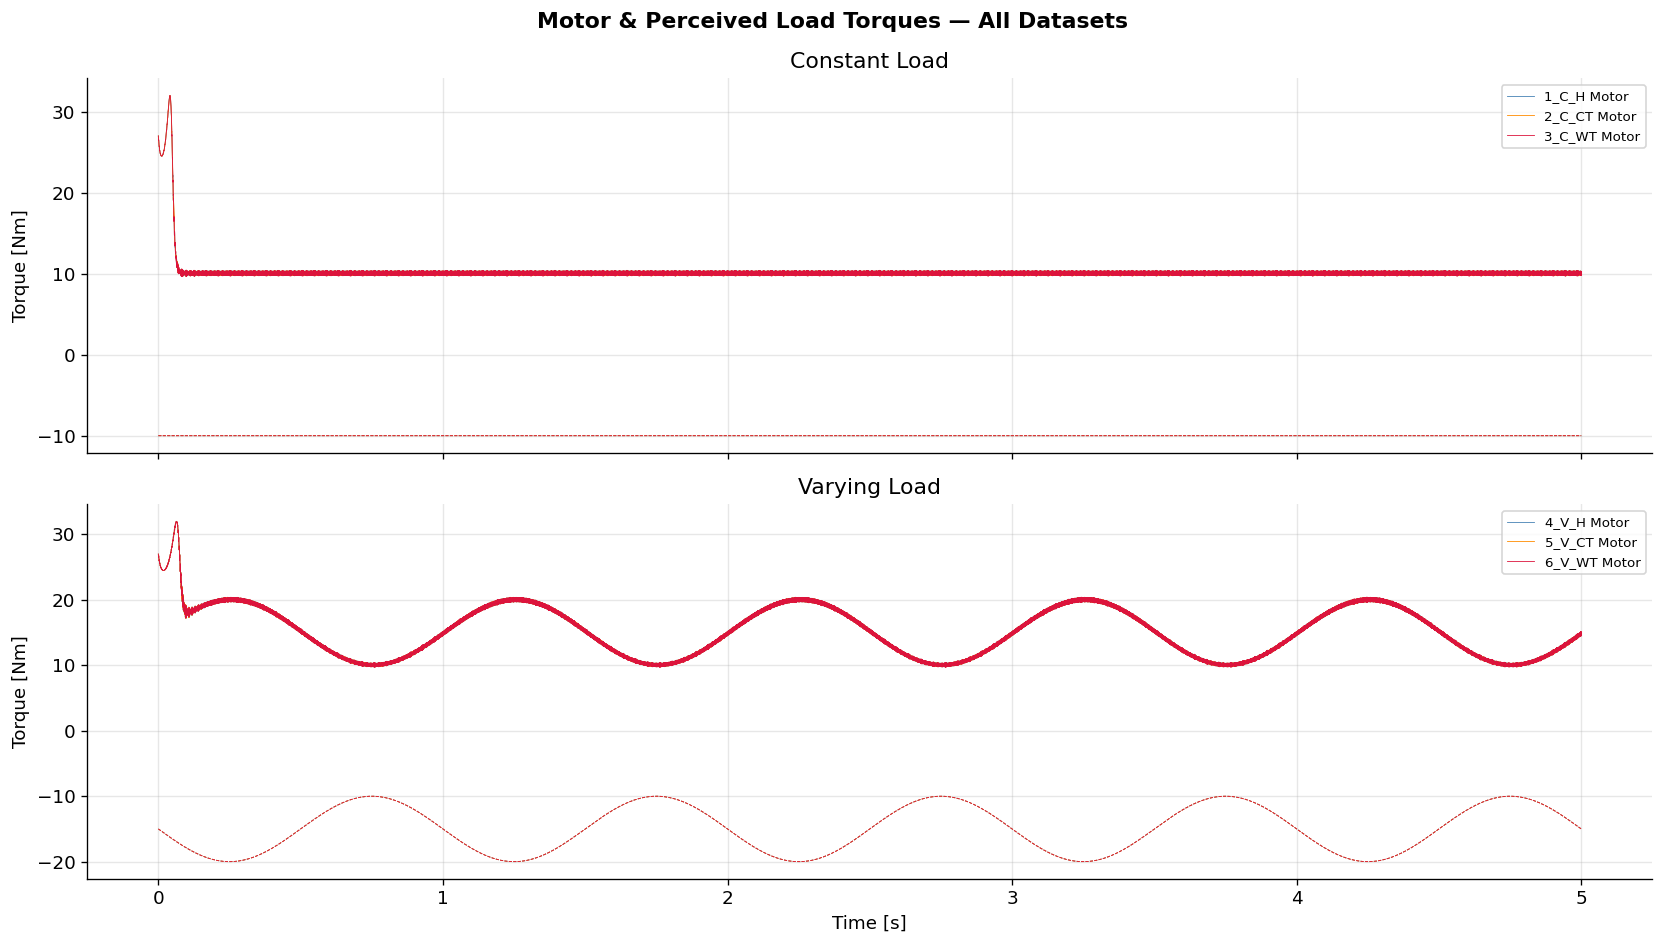

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

colors = {'H': 'steelblue', 'CT': 'darkorange', 'WT': 'crimson'}

for ax, ids, title in [
    (axs[0], ['1_C_H', '2_C_CT', '3_C_WT'], 'Constant Load'),
    (axs[1], ['4_V_H', '5_V_CT', '6_V_WT'], 'Varying Load')
]:
    for dataset_id in ids:
        data   = results[dataset_id]
        ftype  = dataset_id.split('_')[2]
        t_m    = data['force'][:, 2]
        t_l    = -data['force'][:, 6] / 2  # Perceived load (2:1 gear ratio)
        ax.plot(time_array, t_m,  color=colors[ftype], lw=0.5, label=f'{dataset_id} Motor')
        ax.plot(time_array, t_l,  color=colors[ftype], lw=0.5, ls='--')
    ax.set_title(title)
    ax.set_ylabel('Torque [Nm]')
    ax.legend(fontsize=8)

axs[1].set_xlabel('Time [s]')
plt.suptitle('Motor & Perceived Load Torques — All Datasets', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.2. Pinion Angular Velocity

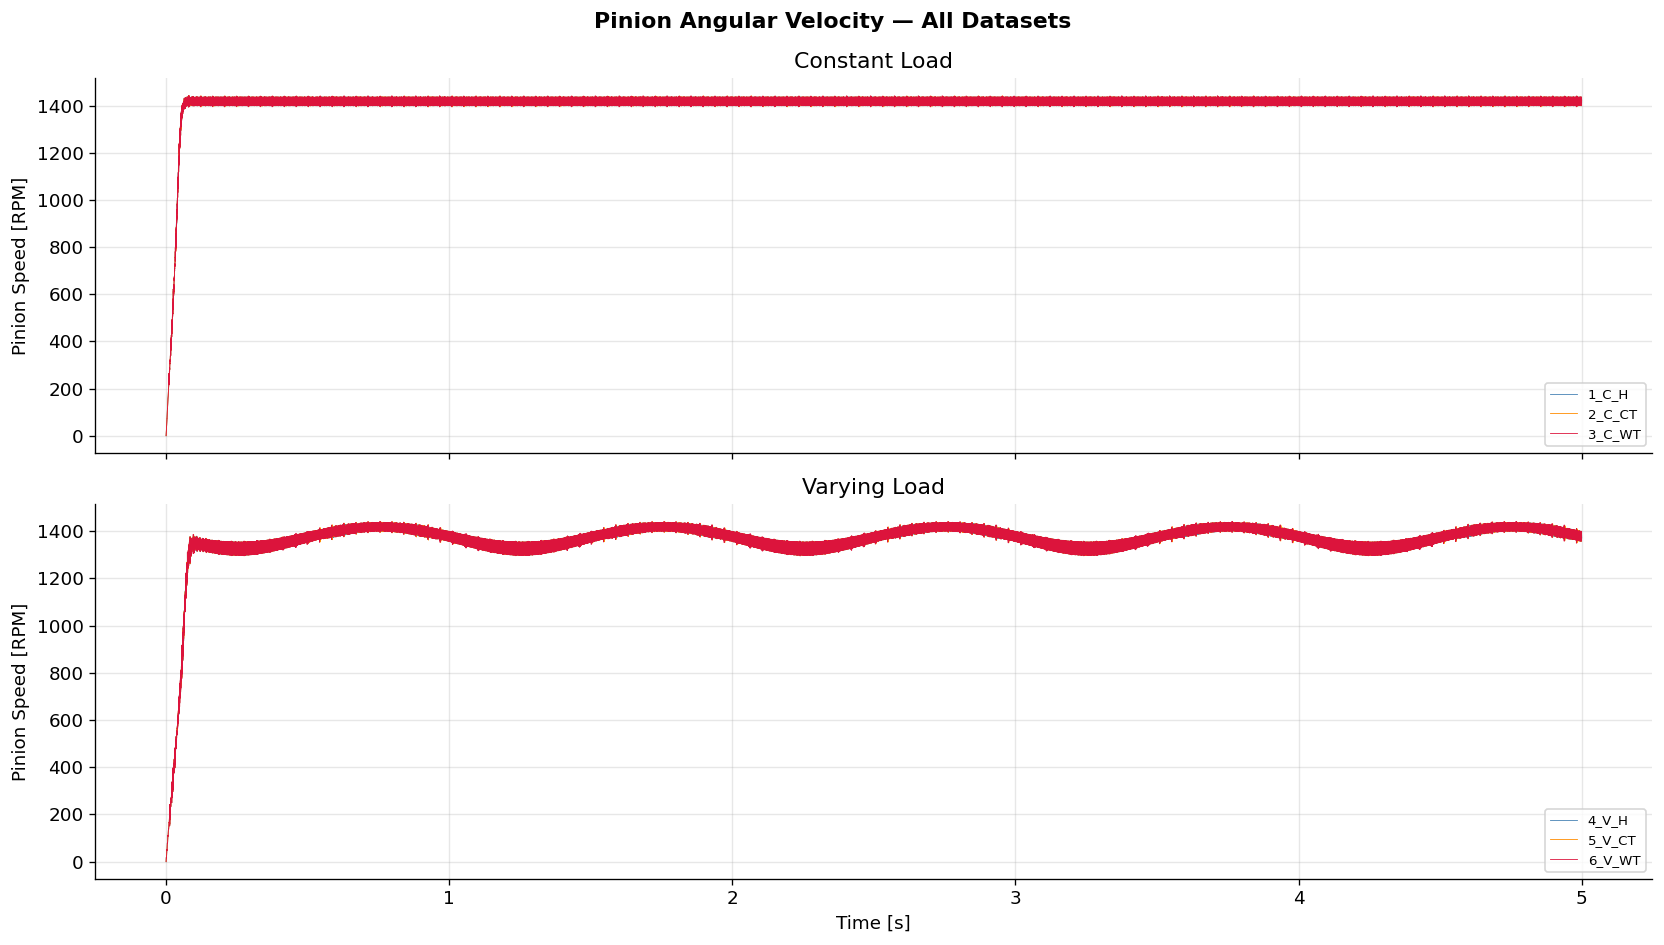

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, ids, title in [
    (axs[0], ['1_C_H', '2_C_CT', '3_C_WT'], 'Constant Load'),
    (axs[1], ['4_V_H', '5_V_CT', '6_V_WT'], 'Varying Load')
]:
    for dataset_id in ids:
        data  = results[dataset_id]
        ftype = dataset_id.split('_')[2]
        ax.plot(time_array, data['velocity'][:, 3] * 60 / (2 * np.pi),
                color=colors[ftype], lw=0.5, label=dataset_id)
    ax.set_title(title)
    ax.set_ylabel('Pinion Speed [RPM]')
    ax.legend(fontsize=8)

axs[1].set_xlabel('Time [s]')
plt.suptitle('Pinion Angular Velocity — All Datasets', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3. Pinion Y-Acceleration (Vibration Signals)

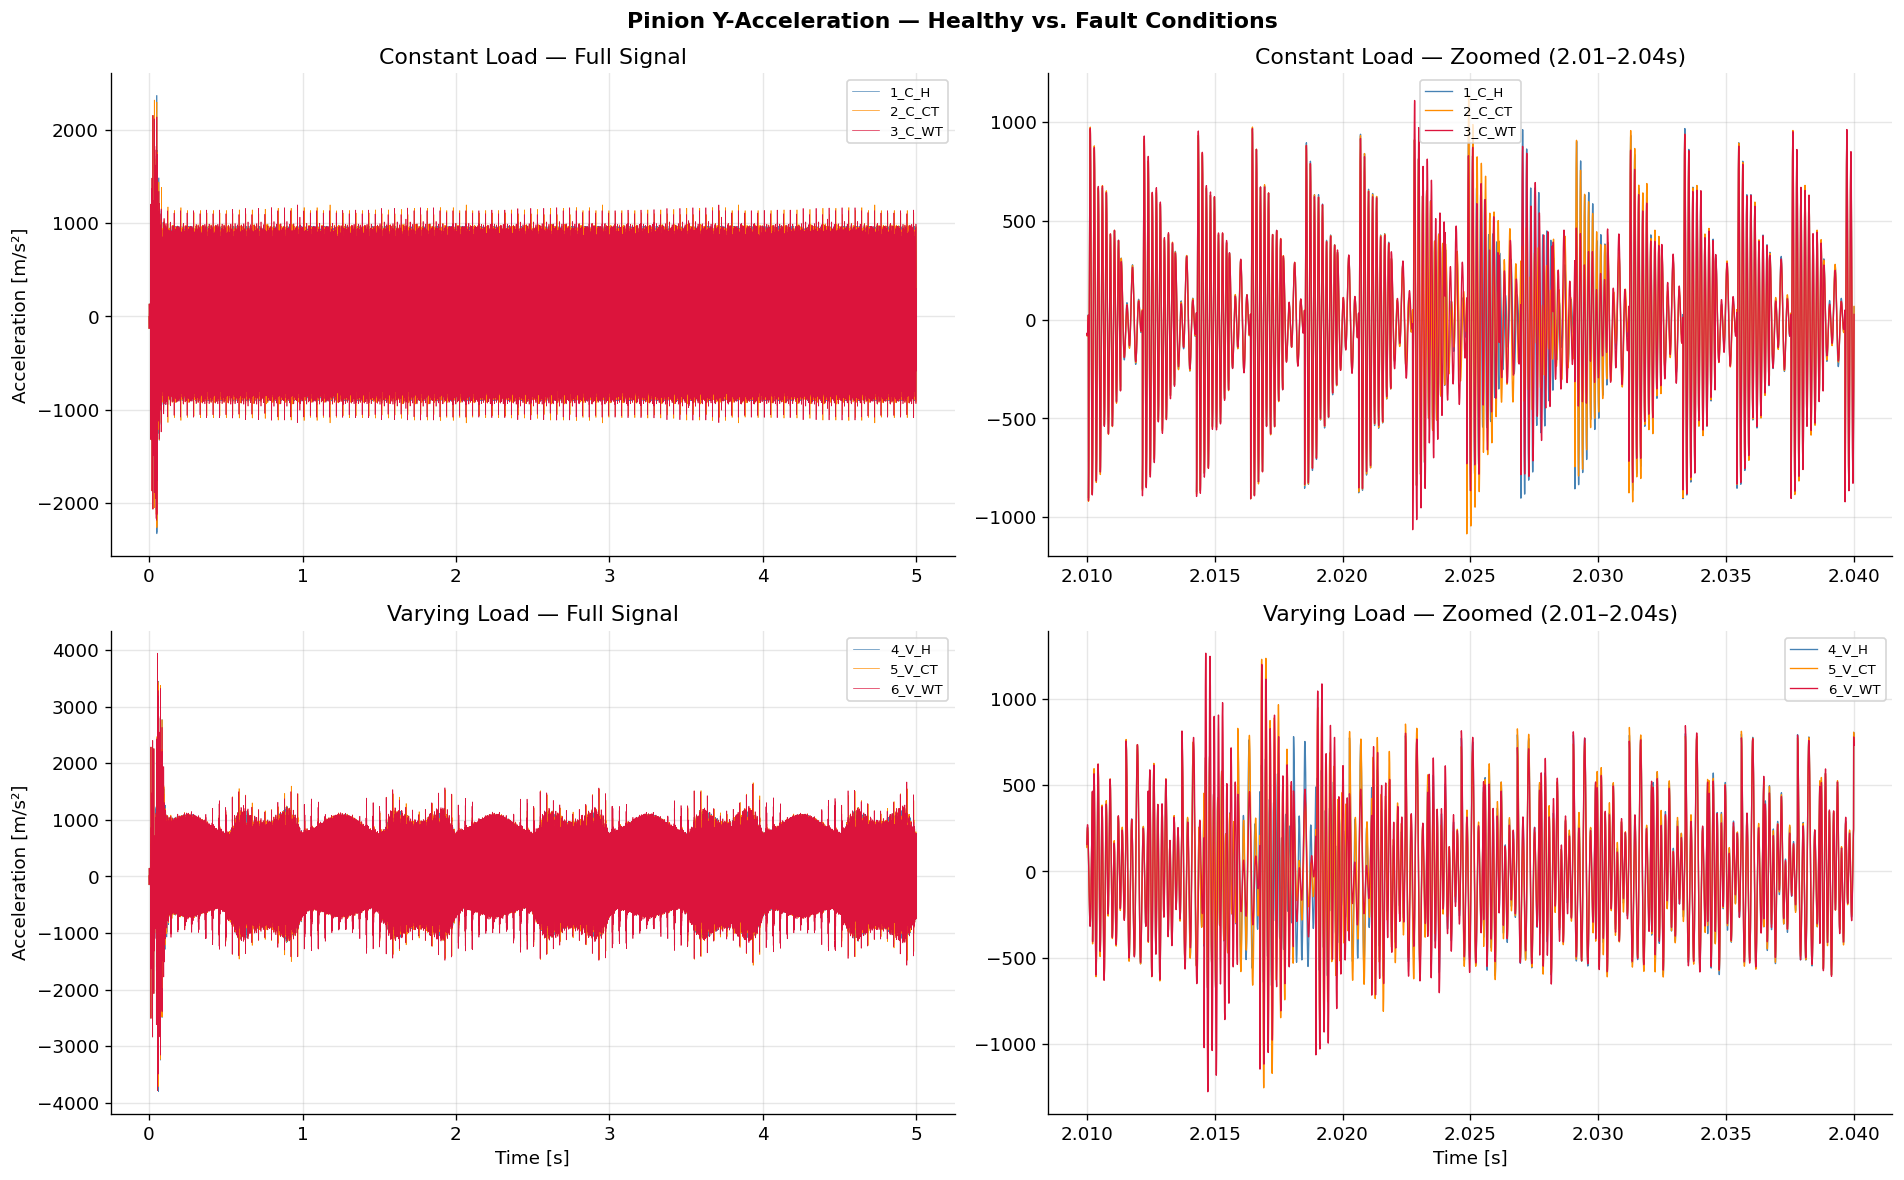

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Zoom window
t_start, t_end = 2.01, 2.04
z_mask = (time_array >= t_start) & (time_array <= t_end)

for row, (ids, title) in enumerate([
    (['1_C_H', '2_C_CT', '3_C_WT'], 'Constant Load'),
    (['4_V_H', '5_V_CT', '6_V_WT'], 'Varying Load')
]):
    for dataset_id in ids:
        data  = results[dataset_id]
        ftype = dataset_id.split('_')[2]
        acc   = data['acceleration'][:, 1]
        axs[row, 0].plot(time_array, acc, color=colors[ftype], lw=0.4, label=dataset_id)
        axs[row, 1].plot(time_array[z_mask], acc[z_mask], color=colors[ftype], lw=0.8, label=dataset_id)

    axs[row, 0].set_title(f'{title} — Full Signal')
    axs[row, 0].set_ylabel('Acceleration [m/s²]')
    axs[row, 0].legend(fontsize=8)
    axs[row, 1].set_title(f'{title} — Zoomed ({t_start}–{t_end}s)')
    axs[row, 1].legend(fontsize=8)

for ax in axs[1]:
    ax.set_xlabel('Time [s]')

plt.suptitle('Pinion Y-Acceleration — Healthy vs. Fault Conditions', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4. Frequency Spectrum Validation

Expected fault frequencies for the constant load case (RPM ≈ 895, fr ≈ 14.9 Hz):
- GMF = fr × 20 ≈ 298 Hz
- Sidebands at GMF ± fr

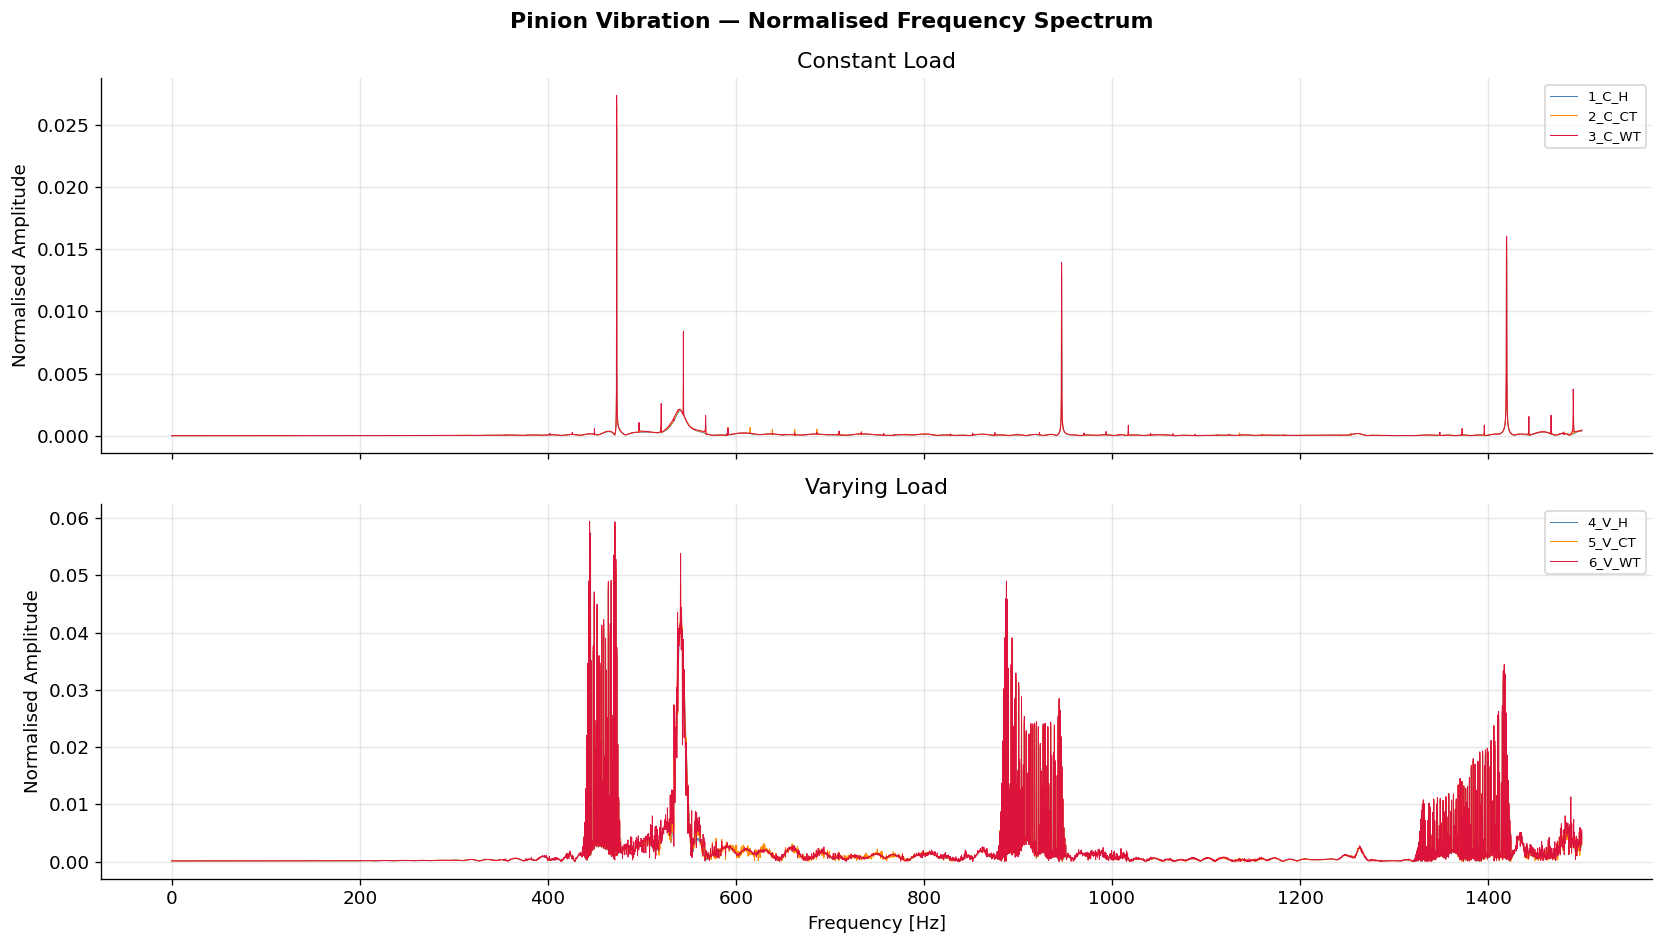

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

N = n_steps
freqs = fftfreq(N, dt)[:N // 2]
freq_mask = freqs <= 1500  # Zoom to relevant frequency range

for ax, ids, title in [
    (axs[0], ['1_C_H', '2_C_CT', '3_C_WT'], 'Constant Load'),
    (axs[1], ['4_V_H', '5_V_CT', '6_V_WT'], 'Varying Load')
]:
    for dataset_id in ids:
        data   = results[dataset_id]
        ftype  = dataset_id.split('_')[2]
        acc    = data['acceleration'][:, 1]
        spec   = np.abs(fft(acc))[:N // 2]
        spec_n = spec / spec.max()
        ax.plot(freqs[freq_mask], spec_n[freq_mask],
                color=colors[ftype], lw=0.6, label=dataset_id)
    ax.set_title(title)
    ax.set_ylabel('Normalised Amplitude')
    ax.legend(fontsize=8)

axs[1].set_xlabel('Frequency [Hz]')
plt.suptitle('Pinion Vibration — Normalised Frequency Spectrum', fontweight='bold')
plt.tight_layout()
plt.show()

---
## Summary

This notebook generates six synthetic vibration datasets from the 8-DOF LPDM gearbox model:

| Step | Implementation |
|---|---|
| Dynamic model | 8-DOF mass-spring-damper (Mohammed et al., 2015) |
| TVMS | Rectangular step function (Chaari et al., 2012) |
| Fault introduction | 10% stiffness reduction — tooth crack and worn teeth |
| Motor excitation | Squirrel cage induction motor torque-speed model |
| Solver | Newmark-Beta implicit integration (β=0.25, γ=0.5) |
| Output | Pinion y-acceleration + angular velocity → 6 CSV files |

The CSV files are consumed by **Notebook 2 — CNN Training & Evaluation**.

**References:**
- Mohammed, O.D. et al. (2015). Influence of dynamic modelling on the fault detection capability for helical gears.
- Chaari, F. et al. (2012). Gearbox vibration signal amplitude and frequency modulation.